In [1]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from IPython.core.debugger import set_trace
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import networkx as nx

ModuleNotFoundError: No module named 'caveclient'

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)
client.materialize.get_tables()

## Functions

In [ ]:
def get_clustered_order(sim_mat, distance_threshold = 0, 
                       n_clusters = None, **kwargs):
    
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None).fit(sim_mat)
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    
    parsed_order = []
    for c in clustered_order:
        if '(' in c:
            c = c.split('(')[1]
            c = c.split(')')[0]
        parsed_order.append(int(c))
    
    return parsed_order

def connectivity_sort(edge, reverted=False):
    # pre and post pt_root_ids list
    if reverted:
        pre = edge.pre_pt_root_id.unique().tolist()
        post = edge.pre_pt_root_id.unique().tolist()
    else:
        
        pre = edge.pre_pt_root_id.unique().tolist()
        post = edge.post_pt_root_id.unique().tolist()
    # initialize conn_mat with length of pre and post pt_root_ids
    conn_mat = np.zeros((len(pre),len(post)))
    print(conn_mat.shape)

    # enumerate every pre_pt_root_id in pre list
    for ix, i in enumerate(pre):
        # locates rows with pre_pt_root_id as such
        subset = edge[edge.pre_pt_root_id == i]

        for jx, j in enumerate(post):
            if j in subset.post_pt_root_id.tolist():
                c = subset[subset.post_pt_root_id==j]['count'].tolist()[0]
                conn_mat[ix,jx] = c
    sim_mat = cosine_similarity(conn_mat)
    clustered_order = get_clustered_order(sim_mat)

    ids_ordered = [pre[i] for i in clustered_order]
    ids_order_map = dict(zip(ids_ordered,[i for i in range(len(ids_ordered))]))

#     gust_only_edge['pre_order'] = gust_only_edge['pre_pt_root_id'].map(ids_order_map)
#     gust_only_edge['post_order'] = gust_only_edge['post_pt_root_id'].map(ids_order_map)
    return ids_order_map, conn_mat, clustered_order

# convert into microns
def convert_to_microns(col, voxel_size=[4.3,4.3,45]):
    return np.vstack(col.values)*voxel_size/1000

def plot_entire(df, title, hue):
    # setting up size and axis handle for plot
    a4_dims = (15, 10)
    fig, ax = pyplot.subplots(1,2,figsize=a4_dims)
    # plots synapses with seaborn module based on classification systems
    syn_pos = convert_to_microns(df['pre_pt_position'])
    x = syn_pos[:, 0]
    y = syn_pos[:, 1]
    z = syn_pos[:, 2]
    sns.scatterplot(x=x, y=y, hue=hue,legend=False,palette='Set2', ax=ax[0]).set_title(title)
    ax[0].set_xlim(30, 180)
    ax[0].set_ylim(400, 520)
    ax[0].set_aspect('equal')
    ax[0].set_xlabel('x (um)')
    ax[0].set_ylabel('y (um)')
    sns.scatterplot(x=x, y=z, hue=hue,legend='auto',palette='Set2', ax=ax[1]).set_title(title)
    ax[1].set_xlim(30, 170)
    ax[1].set_ylim(105, 180)
    ax[1].set_aspect('equal')
    ax[1].set_xlabel('x (um)')
    ax[1].set_ylabel('z (um)')
    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    return syn_pos

def classify_clusters(rnge, clss):
    dct = dict(zip(rnge,np.repeat(clss,30)))
    return dct

def histplot_classes(df, hue,title, hue_order=None, x='post_order'):
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(1,1,1)
    sns.histplot(data=df, x=x, hue=hue, hue_order=hue_order,
                palette="Paired", multiple='layer', bins = len(df[x].unique())).set_title(title)
    ax.set_ylim(0, 35)
    sns.move_legend(ax, "upper right",frameon=False,bbox_to_anchor=(1.15, 1))
    
def histplot_a_class(df, title_hue, length, x='post_order'):
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(1,1,1)
    sns.histplot(data=df, x=x, bins= length,
                palette="Paired", multiple='layer').set_title(title_hue)
    ax.set_ylim(0, 35)

In [ ]:
%matplotlib inline
# tot_df is of order and count column only and comprises ALL the counts
# label_df is of order and count column only and comprises parts of counts
def get_full_axon_df(tot_df, label_df, groupby='order', tot_missing=False, tot=None):
    lst = [i for i in range(tot_df.shape[0])]
    if tot_missing:
        lst = [i for i in range(tot)]
    dct2 = dict(zip(label_df[groupby], label_df['count']))
    dct1 = {lst[i]: 0 for i in range(len(lst))}
    if tot_missing:
        dct1 = {lst[i]: 0.00001 for i in range(len(lst))}
    dct1.update(dct2)
    keys = list(dct1.keys())
    vals = list(dct1.values())
    new_dct = {groupby:keys, 'count':vals}
    df = pd.DataFrame(data=new_dct)
    return df

def get_count_synapse(df, tot, column='label', test='upstream', groupby='order'):
    if isinstance(test, str):
        up = df[df[column]==test].groupby(groupby)['count'].sum().reset_index()
        up = get_full_axon_df(tot, up, groupby=groupby[0])
    else:
        up = df[df[column].isna()].groupby(groupby)['count'].sum().reset_index()
        up = get_full_axon_df(tot, up, groupby=groupby[0])
    return up

def get_count_by_proportionality(df, test, df_groupby_total, label, column='label', groupby='order'):
    df_portion = get_count_synapse(df, df_groupby_total, test=test, column=column, groupby=groupby)
    df_portion['count'] = [i / j * 100 for i,j in zip(df_portion['count'], df_groupby_total['count'])]
    df_portion.name = str(label);
    return df_portion

def plot_percent_stacked_bar(total, args, x='order', only=[]):
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(1,1,1)
    bottom = [0 for i in range(total.shape[0])]
    if len(only) != 0:
        for arg in args:
            if arg.name in only:
                ax.bar(arg[x], arg['count'], bottom=bottom, edgecolor='white', label=arg.name)
                bottom = [i+j for i,j in zip(bottom, arg['count'])]
            else:    
                ax.bar(arg[x], arg['count'], color='#808080', bottom=bottom, edgecolor='white')
                bottom = [i+j for i,j in zip(bottom, arg['count'])]
    else:
        for arg in args:
            ax.bar(arg[x], arg['count'], bottom=bottom, edgecolor='white', label=arg.name)
            bottom = [i+j for i,j in zip(bottom, arg['count'])]
    plt.legend(loc='lower right', bbox_to_anchor=(1,1), ncol=1, prop={"size":20})

################################################################################################################################
# plots proportion of number of synapses of each gustatory downstream partner's class per gustatory neuron with specified order#
################################################################################################################################
# master_df (df for short) needs count of synapse column ('count') and order/bristle/pt_root_id of interest to groupby
# column is the column's name of the hue by which the bar chart is plotted
# groupby is the order/bristle/pt_root_id column to groupby
# only is a list of labels that are plotted with color (others are plotted with grey)
    # only is an empty list by default. Will plot everything with colors if empty.
def plot_percent_stacked_bar_column(df, column, groupby='order', only=[]):
    total = df.groupby(groupby)['count'].sum().reset_index()
    label_lst = [*df[column].unique()]
    subdf_lst = []
    for label in label_lst:
        subdf_lst.append(get_count_by_proportionality(df, label, total, label, column=column, groupby=groupby))
    plot_percent_stacked_bar(total, subdf_lst, only=only, x=groupby[0])
#     return label_lst, total, subdf_lst

def make_others_df(tot_df, remaining_df, groupby):
    df_portion = get_full_axon_df(tot_df, remaining_df, groupby=groupby) # not portion yet
    df_portion['count'] = [i / j * 100 for i,j in zip(df_portion['count'], tot_df['count'])]
    df_portion.name = 'others'
    return df_portion

# df with the classification system by tags
# classes_by_tags: the string column name that classifies the pt_root_id by tags (with ",")
def append_set_class_col(df, classes_by_tags):
    df = df.copy()
    labels = [*df[classes_by_tags].unique()]
    labels_dict = {}
    if any([ ("," in i) for i in labels]):
        for label in labels:
            if (~pd.isna(label)):
                sorted_label = sorted(label.split(','))
                new_label = '_'.join(sorted_label)
                labels_dict.update({label: new_label})
    df['set_class'] = df[classes_by_tags].map(labels_dict)
    return df

In [ ]:
# get bristle tables
bristle_df= client.materialize.query_table('bristle_axon_table')
leg_df = bristle_df.loc[bristle_df.classification_system.str.contains("T1_L")]
gust_df = leg_df.loc[(leg_df.classification_system.str.contains("gust"))
                     |leg_df.cell_type.str.contains("gust")]
leg_df.shape, gust_df.shape

In [ ]:
dwn_df= client.materialize.query_table('downstream_bristle_table_v0')
print(dwn_df.shape)
dwn_df.head()

In [ ]:
# get downstream and upstream partners of gust
gust_down_df = client.materialize.synapse_query(pre_ids=gust_df.pt_root_id)
gust_up_df = client.materialize.synapse_query(post_ids=gust_df.pt_root_id)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

### Gust_downstream edge filtered for >3 or not

In [ ]:
gust_downstream_edge = gust_down_df.groupby(['pre_pt_root_id', 'post_pt_root_id', ],
                        dropna=False).size().sort_values(ascending=False).reset_index(name='count')
gust_downstream_edge = gust_downstream_edge.query("count > 3")

In [ ]:
gust_downstream_edge.pre_pt_root_id.unique()

In [ ]:
# get partners of gust that are gust

## get gust_lst
gust_lst = gust_df.pt_root_id.to_list()

## filter for gust-gust connection
df1 = gust_down_df.loc[(gust_down_df.post_pt_root_id.isin(gust_lst))]
df2 = gust_up_df.loc[(gust_up_df.pre_pt_root_id.isin(gust_lst))]
gust_only_df = pd.concat([df1, df2], axis=0)

In [ ]:
gust_only_edge = gust_only_df.groupby(['pre_pt_root_id', 'post_pt_root_id'], 
                            dropna=False).size().sort_values(ascending=False).reset_index(name='count')

## Gust_downstream connectivity

In [ ]:
# class_df = pd.read_pickle(r'C:\Users\trnan\OneDrive\Desktop\uw\Tutill lab\repos\gustatory_downstream')
# final_class_df = class_df[['Segment IDs','Tags']].reset_index()
# final_class_df = final_class_df.drop(final_class_df[~final_class_df['Segment IDs'].isin(gust_post_ids_ordered)].index)

In [ ]:
# final_class_df = pd.read_csv(r'C:\Users\trnan\OneDrive\Desktop\uw\Tutill lab\repos\MicronsBinder\notebooks\Data.csv')
# final_class_df = final_class_df.rename(columns={'root_id':'pt_root_id'})

In [ ]:
final_class_df = client.materialize.query_table('gustatory_downstream_t1l')

In [ ]:
new_class_dct = dict(zip(final_class_df['pt_root_id'], final_class_df['classification_system']))

In [ ]:
# Removing NaN (non-labeled downstream partners)
gust_downstream_edge['new_class'] = gust_downstream_edge['post_pt_root_id'].map(new_class_dct)
temp = gust_downstream_edge.loc[(~gust_downstream_edge.new_class.isna())]
removed_rows = gust_downstream_edge.shape[0] - temp.shape[0]
removed_unique_downstream_partners = len(gust_downstream_edge.loc[(gust_downstream_edge.new_class.isna())].post_pt_root_id.unique())
print('removed rows = ' + str(removed_rows))
print('removed unique downstream partners = ' + str(removed_unique_downstream_partners))
gust_downstream_edge = temp

# assigning new labeling system
gust_downstream_edge = append_set_class_col(gust_downstream_edge, 'new_class')
gust_downstream_edge = gust_downstream_edge.loc[gust_downstream_edge.set_class != 'error']

In [ ]:
# gust-downstream connectivity dendrogram sorted by cosine similarity with downstream partners being gustatory exculded 
ids_map_gust_downstream, conn_mat_dwn, clustered_order_dwn = connectivity_sort(gust_downstream_edge[~gust_downstream_edge.post_pt_root_id.isin(gust_downstream_edge.pre_pt_root_id)])
gust_downstream_edge['order'] = gust_downstream_edge['pre_pt_root_id'].map(ids_map_gust_downstream)

In [ ]:
len(gust_downstream_edge.post_pt_root_id.unique())

In [ ]:
pre = gust_downstream_edge.pre_pt_root_id.unique().tolist()
post = gust_downstream_edge[~gust_downstream_edge.post_pt_root_id.isin(gust_downstream_edge.pre_pt_root_id)].post_pt_root_id.unique().tolist()
# initialize conn_mat with length of pre and post pt_root_ids
conn_mat = np.zeros((len(pre),len(post)))
print(conn_mat.shape)

# enumerate every pre_pt_root_id in pre list
for ix, i in enumerate(pre):
    # locates rows with pre_pt_root_id as such
    subset = gust_downstream_edge[gust_downstream_edge.pre_pt_root_id == i]

    for jx, j in enumerate(post):
        if j in subset.post_pt_root_id.tolist():
            c = subset[subset.post_pt_root_id==j]['count'].tolist()[0]
            conn_mat[ix,jx] = c

In [ ]:
#clustering the gustatory neurons
gust_pre = gust_downstream_edge.pre_pt_root_id.unique().tolist()
gust_sim_mat = cosine_similarity(conn_mat)
gust_clustered_order = get_clustered_order(gust_sim_mat)
gust_ids_ordered = [gust_pre[i] for i in gust_clustered_order]

In [ ]:
# ordered by gust-gust similarity matrix of gust-gust connectivity 

gust_pre = gust_downstream_edge.pre_pt_root_id.unique().tolist()
gust_sim_mat = cosine_similarity(conn_mat)
gust_clustered_order = get_clustered_order(gust_sim_mat)
gust_ids_ordered = [gust_pre[i] for i in gust_clustered_order]

fig = plt.figure(1, figsize =[12,10])
sim_mat = gust_sim_mat[gust_clustered_order,:]
sim_mat = sim_mat[:,gust_clustered_order]
sns.heatmap(sim_mat)
plt.show()

In [ ]:
gust_downstream_edge[gust_downstream_edge['order'].isin(range(0,2))].post_pt_root_id.unique()

In [ ]:
gust_downstream_group = {}
for i in range(19):
    gust_downstream_group[i] = '1'
for i in range(19, 38):
    gust_downstream_group[i] = '2'

In [ ]:
#clustering the postsynaptic neurons to gust neurons
gust_post = gust_downstream_edge[~gust_downstream_edge.post_pt_root_id.isin(gust_downstream_edge.pre_pt_root_id)].post_pt_root_id.unique().tolist()
gust_post_sim_mat = cosine_similarity(conn_mat.T)
gust_post_clustered_order = get_clustered_order(gust_post_sim_mat)
gust_post_ids_ordered = [gust_post[i] for i in gust_post_clustered_order]

#reordering the connectivity matrix according to both #clusterings
gust_conn_mat_ordered = conn_mat[gust_clustered_order,:]
gust_conn_mat_ordered = gust_conn_mat_ordered[:,gust_post_clustered_order]

In [ ]:
gust_post_id_map = dict(zip(gust_post_ids_ordered,[i for i in range(len(gust_post_ids_ordered))]))

In [ ]:
#plotting
fig = plt.figure(1, figsize =[20,10])
sns.heatmap(gust_conn_mat_ordered, vmin=0, vmax=20)
plt.show()

In [ ]:
# assigning order for post_ids
gust_downstream_edge['post_order'] = gust_downstream_edge['post_pt_root_id'].map(gust_post_id_map)

In [ ]:
# confirming that the new class added covers for every downstream partners (except for interconnection)
gust_downstream_edge.loc[(gust_downstream_edge.new_class.isna()) 
                         & (gust_downstream_edge.post_pt_root_id.isin(gust_post_ids_ordered))]

In [ ]:
# gust_downstream_edge = gust_downstream_edge[gust_downstream_edge.set_class != 'gustatory']

## Plotting number of axon connections per gustatory downstream partners

In [ ]:
df_no_error = gust_downstream_edge.copy()
df_no_error = df_no_error[df_no_error.set_class != 'gustatory']

- defining dataframes with corresponding labels 

In [ ]:
all_ascending_labels = df_no_error[df_no_error.set_class.str.contains('ascending',na=False)].set_class.unique()
not_ascending_labels = df_no_error[~df_no_error.set_class.str.contains('ascending',na=False)].set_class.unique()
intersegmental_labels = df_no_error[df_no_error.set_class.str.contains('intersegmental',na=False)].set_class.unique()
midline_labels = df_no_error[df_no_error.set_class.str.contains('midline',na=False)].set_class.unique()

In [ ]:
all_ascending = df_no_error[df_no_error.set_class.str.contains('ascending',na=False)]
not_ascending = df_no_error[~df_no_error.set_class.str.contains('ascending',na=False)]
intersegmental = df_no_error[df_no_error.set_class.str.contains('intersegmental',na=False)]
midline = df_no_error[df_no_error.set_class.str.contains('midline',na=False)]
name = ['ascending', 'not_ascending', 'intersegmental', 'midline']
# all_intersegmental = gust_downstream_edge[gust_downstream_edge.new_class.str.contains('intersegmental',na=False)].new_class.unique()

In [ ]:
histplot_classes(df_no_error, 'set_class', 'everything')

In [ ]:
for title, i in enumerate([all_ascending, not_ascending, intersegmental, midline]):
    histplot_a_class(i, f'{name[title]}', len(df_no_error.post_order.unique()))

##### Checking for partners between range(x,y)

In [ ]:
histplot_classes(df_no_error[df_no_error.post_order.isin(list(range(56,62)))],'set_class', "13-20")

# proportionality histogram by synapses

- labels (e.g. local, left_local, etc.) are dataframes obtained via querying gust_downstream_edge for set_class with matching labels, see the section above

In [ ]:
plot_percent_stacked_bar_column(gust_downstream_edge, 'set_class', groupby=['order'])
plot_percent_stacked_bar_column(gust_downstream_edge, 'set_class', groupby=['order'], only = all_ascending_labels)

- Fig (1): everything
- Fig (2): only ascending

In [ ]:
plot_percent_stacked_bar_column(gust_downstream_edge, 'set_class', groupby=['order'], only=not_ascending_labels)
plot_percent_stacked_bar_column(gust_downstream_edge, 'set_class', groupby=['order'], only=intersegmental_labels)

- Fig (3): any non-ascending
- Fig (4): only intersegmental

In [ ]:
intersegmental_non_ascending_labels = not_ascending[not_ascending.set_class.str.contains('intersegmental',na=False)].set_class.unique()
intersegmental_ascending_labels = intersegmental[intersegmental.set_class.str.contains('ascending',na=False)].set_class.unique()
bilateral_intersegmental_labels = intersegmental[intersegmental.set_class.str.contains('bilateral',na=False)].set_class.unique()
left_intersegmental_labels = intersegmental[intersegmental.set_class.str.contains('left',na=False)].set_class.unique()

In [ ]:
plot_percent_stacked_bar_column(gust_downstream_edge, 'set_class', groupby=['order'], only=intersegmental_non_ascending_labels)
plot_percent_stacked_bar_column(gust_downstream_edge, 'set_class', groupby=['order'], only=intersegmental_ascending_labels)
plot_percent_stacked_bar_column(gust_downstream_edge, 'set_class', groupby=['order'], only=bilateral_intersegmental_labels)
plot_percent_stacked_bar_column(gust_downstream_edge, 'set_class', groupby=['order'], only=left_intersegmental_labels)

In [ ]:
plot_percent_stacked_bar_column(gust_downstream_edge, 'set_class', groupby=['order'], only=midline_labels)

- Fig (5): only midline

In [ ]:
gust_downstream_edge.groupby(['set_class']).size()

#### Conclusion
- 0-18: has left_bilateral_ascending | slightly more left_ascending | --> more towards the left
- 20-37: more intersegmental_ascending (only 1 notable partner) | also more errors | has 1 right ascending (could be error)| slightly more local_midline_ascending --> in general, more intersegmental --> more contained within the volume
- 19: only intersegmental and bilateral_ascending
- (there are some labeling errors, there's 1 labeled bilateral_ascending whereas it's only bilateral_intersegmental)

## ENDING

## Gust_gust connectivity

In [ ]:
ids_map_gust_gust, conn_mat, clustered_order = connectivity_sort(gust_only_edge, reverted=True)
gust_only_edge['pre_order'] = gust_only_edge['pre_pt_root_id'].map(ids_map_gust_gust)
gust_only_edge['post_order'] = gust_only_edge['post_pt_root_id'].map(ids_map_gust_gust)

### Hardcoded (adjust accordingly)

In [ ]:
dct = {}
dct.update(classify_clusters(range(0,7), 0))
dct.update(classify_clusters(range(7,13), 1))
dct.update(classify_clusters(range(13,26), 2))
dct.update(classify_clusters(range(26,37), 3))
gust_only_edge['category'] = gust_only_edge['pre_order'].map(dct)
gust_id_class = dict(zip(gust_only_edge.pre_pt_root_id, gust_only_edge.category))

In [ ]:
gust_only_df['category'] = gust_only_df['pre_pt_root_id'].map(gust_id_class)

In [ ]:
plot_entire(gust_only_df.loc[(gust_only_df.category == 2) | (gust_only_df.category == 3)], "gust_gust_syn_pos", 
            gust_only_df.loc[(gust_only_df.category == 2) | (gust_only_df.category == 3)].category)

### Resume

In [ ]:
fig = plt.figure(1, figsize =[20,10])

conn_mat_ordered = conn_mat[clustered_order,:]
conn_mat_ordered = conn_mat_ordered[:,clustered_order]

sns.heatmap(conn_mat_ordered, vmin=1, vmax=20)
#f= '../Gust_downstream_syn_connmat_all.png'
#plt.savefig(f)
plt.show()

In [ ]:
smth1 = gust_downstream_edge.copy()
dct_smth = dict(zip(gust_only_edge.pre_pt_root_id, gust_only_edge.pre_order))
smth1['gust_gust_order'] = smth1['pre_pt_root_id'].map(dct_smth)

In [ ]:
plot_percent_stacked_bar_column(smth1, 'set_class', groupby=['gust_gust_order'])

In [ ]:
plot_percent_stacked_bar_column(smth1, 'set_class', groupby=['gust_gust_order'], only=all_ascending_labels)
plot_percent_stacked_bar_column(smth1, 'set_class', groupby=['gust_gust_order'], only=intersegmental_labels)
plot_percent_stacked_bar_column(smth1, 'set_class', groupby=['gust_gust_order'], only=not_ascending_labels)
plot_percent_stacked_bar_column(smth1, 'set_class', groupby=['gust_gust_order'], only=midline_labels)

# Gust-gust assumption classified broadly into 2 groups (hard-coded, adjust by looking at the dendogram to reassign groups)
#### Arguing that there's a similar intra-proportion of both groups in one classification system (gust-gust connectivity vs gust-downstream connectivity) given groups in the another classification system 

In [ ]:
dct1 = dict(zip(gust_downstream_edge.pre_pt_root_id,gust_downstream_edge.order))
dct2 = dict(zip(gust_only_edge.pre_pt_root_id,gust_only_edge.pre_order))

In [ ]:
gust_gust_group = {}
for i in range(13):
    gust_gust_group[i] = '1'
for i in range(13,37):
    gust_gust_group[i] = '2'

In [ ]:
df_gust_group = pd.DataFrame(index=dct1.keys(), columns=['gust_downstream_order'], data=dct1.values()).reset_index()
df_gust_group = df_gust_group.rename({'index':'pre_pt_root_id'}, axis='columns')
df_gust_group['gust_downstream_group'] = df_gust_group['gust_downstream_order'].map(gust_downstream_group)
df_gust_group['gust_gust_order'] = df_gust_group['pre_pt_root_id'].map(dct2)
df_gust_group['gust_gust_group'] = df_gust_group['gust_gust_order'].map(gust_gust_group)

In [ ]:
df_gust_group_edge = df_gust_group.groupby(['gust_downstream_group','gust_gust_group'],
             dropna=True).size().sort_values(ascending=False).reset_index(name='count')

In [ ]:
sns.histplot(df_gust_group[df_gust_group.gust_downstream_group=='1'], x='gust_downstream_group', 
             stat='proportion', hue='gust_gust_group',multiple='stack', hue_order=["1","2"])
sns.histplot(df_gust_group[df_gust_group.gust_downstream_group=='2'], x='gust_downstream_group', 
             stat='proportion', hue='gust_gust_group',multiple='stack')

In [ ]:
sns.histplot(df_gust_group[df_gust_group.gust_gust_group=='1'], x='gust_gust_group', 
             stat='proportion', hue='gust_downstream_group',multiple='stack', hue_order=["1","2"])
sns.histplot(df_gust_group[df_gust_group.gust_gust_group=='2'], x='gust_gust_group', 
             stat='proportion', hue='gust_downstream_group',multiple='stack',hue_order=["1","2"])

## Characterizing each gust from gust_gust based on gust connectivity to other gust

In [ ]:
# how to pick between different classes? (Ward linkage)
## label them on VNC with different colors?
## checks to see (the most common) downstream partners each group is connected to

# Question: the argument is that there is high connectivity within one subclass of GRNs, then the downstream partners of GRNs
# should not be relevant (or rather, each subclass of GRNs could connect to the same class of downstream partner or different 
# classes of downstream partners equally)? Then, why should we look for the most common downstream partner of each subclass? 

In [ ]:
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)

sns.histplot(data=gust_only_edge, ax=ax,
             x="pre_order", bins = len(gust_only_edge.pre_order.unique()),
             palette="Paired", 
             element="bars", legend=True)
ax.set_title("Number of Connections onto other Gust")
ax.set_xlabel("Gustatory axons")
ax.set_ylabel("Number of Connections") # number of partners connected to
# sns.move_legend(ax, "upper right",frameon=False,bbox_to_anchor=(1.15, 1))

In [ ]:
gust_syn = gust_only_edge.groupby(['pre_order']).sum().reset_index()

In [ ]:
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)

sns.barplot(data=gust_syn, x="pre_order",y="count",ax=ax)
ax.set_title("Synapses onto other Gust")
ax.set_xlabel("Gustatory axons")
ax.set_ylabel("Number of Synapses") # number of partners connected to
# sns.move_legend(ax, "upper right",frameon=False,bbox_to_anchor=(1.15, 1))

In [ ]:
# barplots of "Number of Synapses onto other Gust of a Gust"
def barplot_a_gust(pre_order, df, normalized = True):
    if normalized:
        f = plt.figure(figsize=(30,10))
        ax = f.add_subplot(1,1,1)
        df = df[df.pre_order == pre_order]
        sns.barplot(data=df, x="post_order", y="count",ax=ax)
        ax.set_title(f"Synapses onto other Gust of {pre_order}")
        ax.set_xlabel("Gustatory axon")
        ax.set_ylabel("Number of Connections") # number of partners connected to
        plt.ylim(0, 30)
    else:
        f = plt.figure(figsize=(30,10))
        ax = f.add_subplot(1,1,1)
        df = df[df.pre_order == pre_order]
        sns.barplot(data=df, x="post_order", y="count",ax=ax)
        ax.set_title(f"Synapses onto other Gust of {pre_order}")
        ax.set_xlabel("Gustatory axon")
        ax.set_ylabel("Number of Connections") # number of partners connected to

In [ ]:
def get_full_edge(df, ids_map):
    pre_order_lst = [*df.pre_order.unique()]
    post_order_lst = [*df.post_order.unique()]
    for i in pre_order_lst:
        for j in post_order_lst:
            if df.loc[(df.pre_order == i) & (df.post_order == j)]['count'].size < 1:
                df2 = pd.DataFrame(np.array([[[g for g in ids_map if ids_map[g]==i], 
                                              [g for g in ids_map if ids_map[g]==j],
                                               0, i, j]]), 
                                   columns=['pre_pt_root_id', 'post_pt_root_id', 'count', 'pre_order', 'post_order'])
                df = pd.concat([df, df2])
    return df

In [ ]:
edge_with_zeros = get_full_edge(gust_only_edge, ids_map_gust_gust)

In [ ]:
edge_with_zeros

In [ ]:
# for i in range(0,len(ids_map_gust_gust)):
#     barplot_a_gust(i, edge_with_zeros, normalized = True)

In [ ]:
# for i in range(0,len(ids_map_gust_gust)):
#     barplot_a_gust(i, edge_with_zeros, normalized = False)

In [ ]:
# create a vector encoding gustatory axons' synapses onto downstream partners for each gustatory axon
# barplot with downstream partners being x-axis categorical data and y-axis being synapses from each gust (or a group of gust)
## onto a downstream partners
# allows seeing what downstream partner groups stand out the most for each gust (or group of gust)

## Change labeling of gust_down_df for gustatory neurons in the df

In [ ]:
post_class = np.array(['others']*gust_down_df.shape[0])
gust_down_post_gust = gust_down_df.post_pt_root_id.isin(gust_lst).to_numpy()
post_class[gust_down_post_gust] = 'gust'
gust_down_df['post_class'] = post_class

## Proportion of inputs and outputs on other gustatory neurons from/to gustatory neurons

In [ ]:
# Get downstream table with labeling of gust and others for gustatory neurons
    # Get edge table for pre-post-others and pre-post-gust
    # plot hist proportion

In [ ]:
# Get downstream table with labeling of gust and others for gustatory neurons
# Get edge table for pre-post-others and pre-post-gust
gust_dwn_edge = gust_down_df.groupby(['pre_pt_root_id','post_pt_root_id','post_class'], 
                                     dropna=False).size().sort_values(ascending=False).reset_index(name='count')
gust_dwn_edge = gust_dwn_edge.query('count > 3')


In [ ]:
# total
gust_dwn_edge_tot = gust_dwn_edge.groupby(['post_class'], dropna=False).sum().reset_index()
gust_dwn_edge_tot['proportion'] = gust_dwn_edge_tot['count']/gust_dwn_edge_tot['count'].sum() 

In [ ]:
gust_dwn_edge_tot.proportion.to_numpy()

In [ ]:
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(data=gust_dwn_edge_tot, x="post_class", y='proportion').set(title='proportion of synapses made by gustatory neurons')


In [ ]:
sns.set(rc={'figure.figsize':(8,5)})
sns.histplot(data=gust_dwn_edge, x='post_class', stat='proportion', 
             multiple='stack', hue='post_class', hue_order=gust_dwn_edge.post_class.unique()[::-1]).set(title='Total Proportion of Connection Made by Gustatory Neruons')


In [ ]:
gust_dwn_edge['pre_order'] = gust_dwn_edge['pre_pt_root_id'].map(ids_map_gust_downstream)

### Defines percent_stacked_bar_2 using sns

In [ ]:
[i for i in range(5)]

In [ ]:
# df must have column of 'count' for the number of synapses
# df: the df to be plotted
# by: the list of size 2 of strings of the columns names where by[0] is the column where the "counts" are of, 
#     and by[1] is the column with label/classification of the by[0] to be stacked on top of one another
def percent_stacked_bar_2(df, by, tot_missing=False, tot=None):
    total = df.groupby(by[0])['count'].sum().reset_index()
    if tot_missing:
        total = get_full_axon_df(total, total, groupby=by[0][0], tot_missing=tot_missing, tot=tot)
    sum_of = list(df[by[1]].unique())
    items = []
    temp = total.copy() # temp list for culmulative sum of iterated counts of items/labels
    temp['count'] = [i/ j * 100 for i,j in zip(temp['count'], total['count'])]
    label = []
    color_cycle = sns.color_palette(n_colors=len(sum_of))
    sns.barplot(x=by[0][0], y='count', data=temp, color=color_cycle[0])
    label.append(mpatches.Patch(label=sum_of[0], color=color_cycle[0]))
    for i, item in enumerate(sum_of):
        items.append(df[df[by[1]]==item].groupby(by[0])['count'].sum().reset_index())
        items[i] = get_full_axon_df(total, items[i], groupby=by[0][0])
        items[i]['count'] = [i/ j * 100 for i,j in zip(items[i]['count'], total['count'])]
        temp['count'] = temp['count'] - items[i]['count']
#         items[i]['count'] = (items[i-1]['count'] - items[i]['count'])
        if (i+1 < len(sum_of)):
            sns.barplot(x=by[0][0],y='count', data=temp, color=color_cycle[i+1]).set(ylabel='Percent of Synapses')
            label.append(mpatches.Patch(label=sum_of[i+1], color=color_cycle[i+1]))
    plt.legend(handles=label,loc='lower right', bbox_to_anchor=(1,1), ncol=1, prop={"size":15})
    return items

In [ ]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.barplot(data=gust_dwn_edge, x="pre_order", y='count', hue='post_class', estimator = np.sum,
            errwidth=0).set(title='number of synapses made by each gustatory neuron')
plt.ylim(0,500)

### Due to limitations with how percent stack bar plot in this notebook is implemented, bars with 100% blue are acutally ascending bristles (bitter) that makes no connection with any other neuron in the VNC. They're blue 100% by default as a placeholder for empty connection neurons.

In [ ]:
dwn_percentage = percent_stacked_bar_2(gust_dwn_edge, [['pre_order'], 'post_class'])

In [ ]:
# Get upstream table with labeling of gust and others for gustatory neurons
    # Get edge table for post-pre-others and post-pre-gust
    # plot hist proportion

In [ ]:
pre_class = np.array(['others']*gust_up_df.shape[0])
gust_up_pre_gust = gust_up_df.pre_pt_root_id.isin(gust_lst).to_numpy()
pre_class[gust_up_pre_gust] = 'gust'
gust_up_df['pre_class'] = pre_class

In [ ]:
# groupby post-pre-preclass
gust_up_edge = gust_up_df.groupby(['post_pt_root_id','pre_pt_root_id','pre_class'], 
                                     dropna=False).size().sort_values(ascending=False).reset_index(name='count')
gust_up_edge = gust_up_edge.query('count > 3')

# total of 'gust' and 'others'
gust_up_edge_tot = gust_up_edge.groupby(['pre_class'], dropna=False).sum().reset_index()
gust_up_edge_tot['proportion'] = gust_up_edge_tot['count']/gust_up_edge_tot['count'].sum() 

In [ ]:
gust_up_edge_tot.proportion.to_numpy()

In [ ]:
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(data=gust_up_edge_tot, x="pre_class", y='proportion').set(title='proportion of synapses received by gustatory neurons')


In [ ]:
sns.set(rc={'figure.figsize':(8,5)})
sns.histplot(data=gust_up_edge, x='pre_class',stat='proportion',
             hue='pre_class').set(title='Total Proportion of Connection Made by Gustatory Neruons')

In [ ]:
# ordering gustatory neurons by cosine similarity based on their downstream connectivity
gust_up_edge['post_order'] = gust_up_edge['post_pt_root_id'].map(ids_map_gust_downstream)

In [ ]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.barplot(data=gust_up_edge, x="post_order", y='count', hue='pre_class', estimator=np.sum,
            errwidth=0).set(title='number of synapses received by each gustatory neuron')

In [ ]:
up_percentage = percent_stacked_bar_2(gust_up_edge, [['post_order'], 'pre_class'])

### Analysis of proportion of synapses based on 'gust' and 'others' without some post_pt_root_id

In [ ]:
gust_rows = [pd.DataFrame({'id':'na','created':'na',
                           'superceded_id':'na', 'valid':'na',
                           'classification_system':'gust',
                            'cell_type':'na',
                            'pt_supervoxel_id':'na',
                            'pt_root_id':[i],
                            'pt_position':'na'}) for i in gust_lst]
gust_rows = pd.concat(gust_rows, axis=0).reset_index().iloc[:,1:]
full_final_class_df = final_class_df.copy()
full_final_class_df = append_set_class_col(full_final_class_df, 'classification_system')
# full_final_class_df = pd.concat([full_final_class_df, gust_rows]).reset_index(drop=True)

In [ ]:
without_some = pd.merge(gust_dwn_edge,full_final_class_df, 
                                      left_on='post_pt_root_id', right_on='pt_root_id')[['pre_pt_root_id',
                                                                                         'post_pt_root_id',
                                                                                         'post_class',
                                                                                         'classification_system',
                                                                                         'pre_order',
                                                                                         'set_class',
                                                                                         'count']]
without_some['gust_order'] = without_some['pre_pt_root_id'].map(ids_map_gust_gust)

In [ ]:
without_some = without_some.loc[without_some.set_class!='error']
without_some_gust = without_some.loc[without_some.set_class!='gustatory'] # removing gustatory

In [ ]:
ids_order_gust_map, conn_mat_gust, gust_clustered_order_gust_gust = connectivity_sort(gust_only_edge, reverted=True)

In [ ]:
ids_order_everything_map, conn_mat_everything, gust_clustered_order_everything = connectivity_sort(without_some_gust)

In [ ]:
gust_pre = without_some.pre_pt_root_id.unique().tolist()
gust_sim_mat = cosine_similarity(conn_mat_gust)
gust_clustered_order_gust_gust = get_clustered_order(gust_sim_mat)
gust_ids_ordered = [gust_pre[i] for i in gust_clustered_order_gust_gust]

sim_mat = gust_sim_mat[gust_clustered_order_gust_gust,:]
sim_mat = sim_mat[:,gust_clustered_order_gust_gust]
sns.heatmap(sim_mat)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.show()

In [ ]:
lst_gust = gust_only_edge.pre_pt_root_id.unique().tolist()
lst_all = without_some.pre_pt_root_id.unique().tolist()
lst_gust_pos_map = dict(zip(lst_gust,[i for i in range(0,len(lst_gust))]))
original_order = [lst_gust_pos_map[i] for i in lst_all]
gust_only_sim_mat_by_everything = gust_sim_mat[original_order, :]
gust_only_sim_mat_by_everything = gust_only_sim_mat_by_everything[:, original_order]

In [ ]:
gust_only_sim_mat_by_everything = gust_only_sim_mat_by_everything[gust_clustered_order_everything,:]
gust_only_sim_mat_by_everything = gust_only_sim_mat_by_everything[:,gust_clustered_order_everything]
sns.heatmap(gust_only_sim_mat_by_everything)
plt.show()

In [ ]:
conn_mat_gust_by_gust = conn_mat_gust[gust_clustered_order_gust_gust,:]
conn_mat_gust_by_gust = conn_mat_gust_by_gust[:,gust_clustered_order_gust_gust]
sns.heatmap(conn_mat_gust_by_gust, vmin=1, vmax=20)
plt.show()

In [ ]:
lst_gust = gust_only_edge.pre_pt_root_id.unique().tolist()
lst_all = without_some.pre_pt_root_id.unique().tolist()
lst_gust_pos_map = dict(zip(lst_gust,[i for i in range(0,len(lst_gust))]))
original_order = [lst_gust_pos_map[i] for i in lst_all]
conn_mat_gust_by_all = conn_mat_gust[original_order, :]
conn_mat_gust_by_all = conn_mat_gust_by_all[:, original_order]

In [ ]:
conn_mat_gust_by_all = conn_mat_gust_by_all[gust_clustered_order_everything,:]
conn_mat_gust_by_all = conn_mat_gust_by_all[:,gust_clustered_order_everything]
sns.heatmap(conn_mat_gust_by_all, vmin=1, vmax=20)
plt.show()

In [ ]:
gust_everything_sim_mat = cosine_similarity(conn_mat_everything)

sim_mat = gust_everything_sim_mat[gust_clustered_order_everything,:]
sim_mat = sim_mat[:,gust_clustered_order_everything]
sns.heatmap(sim_mat)
plt.show()

In [ ]:
len(without_some.post_pt_root_id.unique())

In [ ]:
without_some_and = without_some.loc[~((without_some.set_class.str.contains('bilateral')) &
                                    (without_some.set_class.str.contains('intersegmental')))]

In [ ]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.barplot(data=without_some, x="pre_order", y='count', hue='post_class', estimator = np.sum,
            errwidth=0).set(title='number of synapses made by each gustatory neuron with some downstream partners excluded')
plt.ylim(0, 500)

In [ ]:
dwn_percent_without_some = percent_stacked_bar_2(without_some, [['pre_order'], 'post_class'])

###  When computing average percentage of connection of a group, only use dwn_percent_without_some[1] because that's the percentage of gust-gust connectivity that has shows 0% where bitter neurons are. Otherwise, gust-others where bitter neurons are 100% according to the table, which is not true because bitter neurons make no connection whatsoever in the VNC.
- adjust ranges accordingly. Hard-coded here

In [ ]:
dwn_percent_without_some[1].loc[(dwn_percent_without_some[1].pre_order.isin(range(24)))]['count'].sum()/24

In [ ]:
without_some_and.groupby(['set_class']).size()

In [ ]:
without_some_and.groupby(['post_class']).size()

In [ ]:
sns.set(rc={'figure.figsize':(15,8.27)})
plt_without_some_and = sns.barplot(data=without_some_and, x="pre_order", y='count', hue='post_class', estimator = np.sum,
            errwidth=0).set(title='number of synapses made by each gustatory neuron without bilateral intersegmental')
plt.ylim(0, 500)

In [ ]:
dwn_percent_without_bilateral_intersegmental=percent_stacked_bar_2(without_some_and, 
                                                                   [['pre_order'], 'post_class'], 
                                                                   tot_missing=True, tot=38)
sns.set(rc={'figure.figsize':(11.7,8.27)})


In [ ]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.barplot(data=without_some, x="gust_order", y='count', hue='post_class', estimator = np.sum,
            errwidth=0).set(title='number of synapses made by each gustatory neuron ordered on gustatory order')
plt.ylim(0, 500)

In [ ]:
nothing = percent_stacked_bar_2(without_some, [['gust_order'], 'post_class'])

In [ ]:
only_bilateral = without_some.loc[((without_some.set_class.str.contains('bilateral')) &
                                    (without_some.set_class.str.contains('intersegmental')))]
missing = without_some[~without_some.pre_pt_root_id.isin(only_bilateral.pre_pt_root_id.unique())]
missing_pt_root_id = [*missing.pre_pt_root_id.unique()]
missing_pre_order = [*missing.pre_order.unique()]
missing_gust_order = [*missing.gust_order.unique()]

only_bilateral_missing = pd.DataFrame({'pre_pt_root_id':missing_pt_root_id,'post_pt_root_id':'na',
                                       'post_class':'na', 'classification_system':'na',
                                       'pre_order':missing_pre_order,
                                       'count':[*np.zeros(len(missing_pt_root_id)).astype('int32')],
                                       'gust_order':missing_gust_order})
only_bilateral = only_bilateral.sort_values(by='set_class')
only_bilateral = pd.concat([only_bilateral, only_bilateral_missing])

ids_order_map, conn_mat_bilateral, gust_clustered_order_bilateral = connectivity_sort(only_bilateral) #conn_mat_bilateral connectivity matrix
gust_bilateral_sim_mat = cosine_similarity(conn_mat_bilateral) #gust_sim_mat_bilateral similarity matrix wrt gustatory

In [ ]:
fig = plt.figure(1, figsize =[12,10])
gust_bilateral_sim_mat_by_bilateral = gust_bilateral_sim_mat[gust_clustered_order_bilateral,:]
gust_bilateral_sim_mat_by_bilateral = gust_bilateral_sim_mat_by_bilateral[:,gust_clustered_order_bilateral]
sns.heatmap(gust_bilateral_sim_mat_by_bilateral)
plt.show()

In [ ]:
lst_bilateral = only_bilateral.pre_pt_root_id.unique().tolist()
lst_all = without_some.pre_pt_root_id.unique().tolist()
lst_bilateral_pos_map = dict(zip(lst_bilateral,[i for i in range(0,len(lst_bilateral))]))
original_order = [lst_bilateral_pos_map[i] for i in lst_all]
gust_bilateral_sim_mat_by_everything = gust_bilateral_sim_mat[original_order,:]
gust_bilateral_sim_mat_by_everything = gust_bilateral_sim_mat_by_everything[:,original_order]

In [ ]:
without_some.pre_pt_root_id.unique()

In [ ]:
only_bilateral.pre_pt_root_id.unique()[original_order]

In [ ]:
only_bilateral.post_pt_root_id.unique()

In [ ]:
fig = plt.figure(1, figsize =[12,10])
gust_bilateral_sim_mat_by_everything = gust_bilateral_sim_mat_by_everything[gust_clustered_order_everything,:]
gust_bilateral_sim_mat_by_everything = gust_bilateral_sim_mat_by_everything[:,gust_clustered_order_everything]
sns.heatmap(gust_bilateral_sim_mat_by_everything)
plt.show()

In [ ]:
fig = plt.figure(1, figsize =[12,10])
conn_mat_bilateral_by_bilateral = conn_mat_bilateral[gust_clustered_order_bilateral,:]
sns.heatmap(conn_mat_bilateral_by_bilateral)
plt.show()

In [ ]:
lst_bilateral = only_bilateral.pre_pt_root_id.unique().tolist()
lst_all = without_some.pre_pt_root_id.unique().tolist()
lst_bilateral_pos_map = dict(zip(lst_bilateral,[i for i in range(0,len(lst_bilateral))]))
original_order = [lst_bilateral_pos_map[i] for i in lst_all]
gust_bilateral_conn_mat_by_everything = conn_mat_bilateral[original_order]

In [ ]:
fig = plt.figure(1, figsize =[12,10])
gust_bilateral_conn_mat_by_everything = gust_bilateral_conn_mat_by_everything[gust_clustered_order_everything,:]
sns.heatmap(gust_bilateral_conn_mat_by_everything)
plt.show()

In [ ]:
ids_order_everything_map, conn_mat_everything, gust_clustered_order_everything = connectivity_sort(without_some)

In [ ]:
conn_mat_everything_by_all = conn_mat_everything[gust_clustered_order_everything,:]
sns.heatmap(conn_mat_everything_by_all)
plt.show()

In [ ]:
lst_bilateral = only_bilateral.pre_pt_root_id.unique().tolist()
lst_all = without_some.pre_pt_root_id.unique().tolist()
lst_all_pos_map = dict(zip(lst_all,[i for i in range(0,len(lst_all))]))
original_order = [lst_all_pos_map[i] for i in lst_bilateral]
conn_mat_everything_by_bilateral = conn_mat_everything[original_order]

In [ ]:
conn_mat_everything_by_bilateral = conn_mat_everything_by_bilateral[gust_clustered_order_bilateral,:]
sns.heatmap(conn_mat_everything_by_bilateral)
plt.show()

In [ ]:
without_some_edge = without_some.groupby(['gust_order']).sum().reset_index()

ascending = without_some[without_some.set_class.str.contains('ascending')]
ascending_edge = ascending.groupby(['gust_order']).sum().reset_index()
synapse_ascending = get_full_axon_df(without_some_edge,ascending_edge, groupby='gust_order')

intersegmental = without_some[without_some.set_class.str.contains('intersegmental')]
intersegmental_edge = intersegmental.groupby(['gust_order']).sum().reset_index()
synapse_intersegmental = get_full_axon_df(without_some_edge,intersegmental_edge, groupby='gust_order')

gustatory = without_some[without_some.set_class.str.contains('gustatory')]
gustatory_edge = gustatory.groupby(['gust_order']).sum().reset_index()
synapse_gustatory = get_full_axon_df(without_some_edge,gustatory_edge, groupby='gust_order')

left = without_some[without_some.set_class.str.contains('left')]
left_edge = left.groupby(['gust_order']).sum().reset_index()
synapse_left = get_full_axon_df(without_some_edge,left_edge, groupby='gust_order')

bilateral = without_some[without_some.set_class.str.contains('bilateral')]
bilateral_edge = bilateral.groupby(['gust_order']).sum().reset_index()
synapse_bilateral = get_full_axon_df(without_some_edge,bilateral_edge, groupby='gust_order')

In [ ]:
plt.figure()
sns.barplot(data=synapse_ascending, x="gust_order", y='count', estimator = np.sum,
            errwidth=0, color='red').set(title='ascending', ylim=(0,400))

plt.figure()
sns.barplot(data=synapse_intersegmental, x="gust_order", y='count', estimator = np.sum,
            errwidth=0, color='violet').set(title='intersegmental', ylim=(0,400))

plt.figure()
sns.barplot(data=synapse_gustatory, x="gust_order", y='count', estimator = np.sum,
            errwidth=0, color='green').set(title='Gustatory', ylim=(0,400))

plt.figure()
sns.barplot(data=synapse_left, x="gust_order", y='count', estimator = np.sum,
            errwidth=0, color='orange').set(title='left', ylim=(0,400))

plt.figure()
sns.barplot(data=synapse_bilateral, x="gust_order", y='count', estimator = np.sum,
            errwidth=0, color='purple').set(title='bilateral', ylim=(0,400))

In [ ]:
ascending_edge = ascending.groupby(['pre_order']).sum().reset_index()
synapse_ascending_by_downstream = get_full_axon_df(without_some_edge,ascending_edge, groupby='pre_order')

intersegmental_edge = intersegmental.groupby(['pre_order']).sum().reset_index()
synapse_intersegmental_by_downstream = get_full_axon_df(without_some_edge,intersegmental_edge, groupby='pre_order')

gustatory_edge = gustatory.groupby(['pre_order']).sum().reset_index()
synapse_gustatory_by_downstream = get_full_axon_df(without_some_edge,gustatory_edge, groupby='pre_order')

left_edge = left.groupby(['pre_order']).sum().reset_index()
synapse_left_by_downstream = get_full_axon_df(without_some_edge,left_edge, groupby='pre_order')

bilateral_edge = bilateral.groupby(['pre_order']).sum().reset_index()
synapse_bilateral_by_downstream = get_full_axon_df(without_some_edge,bilateral_edge, groupby='pre_order')

In [ ]:
plt.figure()
sns.barplot(data=synapse_ascending_by_downstream, x="pre_order", y='count', estimator = np.sum,
            errwidth=0, color='red').set(title='ascending', ylim=(0,400))

plt.figure()
sns.barplot(data=synapse_intersegmental_by_downstream, x="pre_order", y='count', estimator = np.sum,
            errwidth=0, color='violet').set(title='intersegmental', ylim=(0,400))

plt.figure()
sns.barplot(data=synapse_gustatory_by_downstream, x="pre_order", y='count', estimator = np.sum,
            errwidth=0, color='green').set(title='gustatory', ylim=(0,400))

plt.figure()
sns.barplot(data=synapse_left_by_downstream, x="pre_order", y='count', estimator = np.sum,
            errwidth=0, color='orange').set(title='left', ylim=(0,400))

plt.figure()
sns.barplot(data=synapse_bilateral_by_downstream, x="pre_order", y='count', estimator = np.sum,
            errwidth=0, color='purple').set(title='bilateral', ylim=(0,400))

### Assigning labels (gust-gust groups) and (gust-downstream groups) (Hard-coded! Adjust accordingly based on new groups)

In [ ]:
gust_gust_group_dct = {}
gust_gust_group_dct.update(classify_clusters(range(0,30), 'G1'))
gust_gust_group_dct.update(classify_clusters(range(30,35), 'G2' ))
gust_gust_group_dct.update(classify_clusters(range(35,len(without_some.gust_order.unique()+1)), 'G3'))

gust_downstream_group_dct = {}
gust_downstream_group_dct.update(classify_clusters(range(0,24), 'D1' ))
gust_downstream_group_dct.update(classify_clusters(range(24,29), 'D2'))
gust_downstream_group_dct.update(classify_clusters(range(29,len(without_some.pre_order.unique())), 'D3'))

without_some['gust_gust_cluster_group'] = without_some['gust_order'].map(gust_gust_group_dct)
without_some['gust_downstream_cluster_group'] = without_some['pre_order'].map(gust_downstream_group_dct)

# combining both cluster groups into a combined group represented by a column for the without_some df
combined_cluster_lst= np.vstack([without_some.gust_gust_cluster_group,without_some.gust_downstream_cluster_group]).T.tolist()
combined_cluster_lst = [','.join(i) for i in combined_cluster_lst]
combined_cluster_dct = dict(zip(without_some.pre_pt_root_id,combined_cluster_lst))
without_some['combined_group'] = without_some['pre_pt_root_id'].map(combined_cluster_dct)

In [ ]:
combined_cluster_lst

In [ ]:
dct_color = dict(zip(without_some.gust_downstream_cluster_group.unique(),sns.color_palette("husl", 3)))
without_some['color'] = without_some['gust_downstream_cluster_group'].map(dct_color)

In [ ]:
sum_df = without_some.groupby(['combined_group','set_class']).sum()
sum_dict = without_some.groupby(['combined_group'])['count'].sum().to_dict()
post_sum_dict = without_some.groupby(['set_class'])['count'].sum().to_dict()
fracts = []
for ix,i in sum_df.iterrows():
    l = ix[0]
    count = i['count']
    fract = count/sum_dict[l]
    fracts.append(fract)
    
sum_df['fract_synapses'] = fracts

In [ ]:
# ascending_dct = dict(zip(without_some.post_pt_root_id, without_some.classification_system.str.contains('ascending')))
# bilateral_dct = dict(zip(without_some.post_pt_root_id, without_some.classification_system.str.contains('bilateral')))
# intersegmental_dct = dict(zip(without_some.post_pt_root_id, without_some.classification_system.str.contains('intersegmental')))
# gustatory_dct = dict(zip(without_some.post_pt_root_id, without_some.classification_system.str.contains('gustatory')))
# left_dct = dict(zip(without_some.post_pt_root_id, without_some.classification_system.str.contains('left')))

# without_some['ascending'] = without_some.post_pt_root_id.map(ascending_dct)
# without_some['bilateral'] = without_some.post_pt_root_id.map(bilateral_dct)
# without_some['intersegmental'] = without_some.post_pt_root_id.map(intersegmental_dct)
# without_some['gustatory'] = without_some.post_pt_root_id.map(gustatory_dct)
# without_some['left'] = without_some.post_pt_root_id.map(left_dct)

### Testing

In [ ]:
ascending_df = without_some[without_some.set_class.str.contains('ascending')]
ascending_df['overarching_class'] = np.repeat('ascending',ascending_df.shape[0])

intersegmental_df = without_some[without_some.set_class.str.contains('intersegmental')]
intersegmental_df['overarching_class'] = np.repeat('intersegmental',intersegmental_df.shape[0])

bilateral_df = without_some[without_some.set_class.str.contains('bilateral')]
bilateral_df['overarching_class'] = np.repeat('bilateral',bilateral_df.shape[0])

gustatory_df = without_some[without_some.set_class.str.contains('gustatory')]
gustatory_df['overarching_class'] = np.repeat('gustatory',gustatory_df.shape[0])

left_df = without_some[without_some.set_class.str.contains('left')]
left_df['overarching_class'] = np.repeat('left',left_df.shape[0])


In [ ]:
overall = pd.concat([ascending_df,intersegmental_df,bilateral_df,gustatory_df,left_df])

In [ ]:
ascending_df.groupby(['combined_group','color','overarching_class']).sum()

In [ ]:
ascending_df.groupby(['combined_group','color','overarching_class']).sum()['count'].sum()

In [ ]:
overall.groupby(['overarching_class'])['count'].sum().to_dict()

In [ ]:
overall_sum = overall.groupby(['combined_group','color','overarching_class']).sum()
sum_dict = without_some.groupby(['combined_group'])['count'].sum().to_dict()
post_sum_dict = overall.groupby(['overarching_class'])['count'].sum().to_dict()
fracts = []
for ix,i in overall_sum.iterrows():
    l = ix[0]
    count = i['count']
    fract = count/sum_dict[l]
    fracts.append(fract)
    
overall_sum['fract_synapses'] = fracts

In [ ]:
overall_sum.head(10)

In [ ]:
overall_sum_by_Ds = overall_sum.reset_index()
overall_sum_by_Ds = overall_sum_by_Ds[overall_sum_by_Ds.combined_group!='G2,D2']
overall_sum_by_Ds['combined_group'] = overall_sum_by_Ds['combined_group'].replace({'G1,D1':'D1','G3,D1':'D1','G3,D3':'D3','G1,D3':'D3'})

In [ ]:
sns.violinplot(data=overall_sum_by_Ds, x="overarching_class", y="count", hue='combined_group', split=True)

In [ ]:
overall_sum_by_Gs = overall_sum.reset_index()
overall_sum_by_Gs = overall_sum_by_Gs[overall_sum_by_Gs.combined_group!='G2,D2']
overall_sum_by_Gs['combined_group'] = overall_sum_by_Gs['combined_group'].replace({'G1,D1':'G1','G1,D3':'G1','G3,D1':'G3','G3,D3':'G3'})

In [ ]:
sns.violinplot(data=overall_sum_by_Gs, x="overarching_class", y="count", hue='combined_group', split=True)

In [ ]:
sns.set(style='white', font_scale =2)
fig, ax = plt.subplots(figsize=(10,20))

sns.scatterplot('combined_group', 'overarching_class', c=overall_sum.reset_index().color,
                s=overall_sum.fract_synapses.to_numpy()*1000, 
                legend=False,  data = overall_sum.reset_index())
sns.despine(bottom=True)
sns.set(rc={'figure.facecolor':(0,0,0,0)})
figname = 'your_figname.png'

In [ ]:
sns.set(style='white', font_scale =2)
fig, ax = plt.subplots(figsize=(10,20))

sns.scatterplot('combined_group', 'set_class', s=sum_df.fract_synapses.to_numpy()*1000, legend=False,  data = sum_df.reset_index())
sns.despine(bottom=True)
sns.set(rc={'figure.facecolor':(0,0,0,0)})

In [ ]:
overall_sum_by_axon = overall.groupby(['combined_group', 'pre_order', 'overarching_class']).sum().reset_index()

In [ ]:
sns.barplot(data=overall_sum_by_axon, x="pre_order",y='count',hue='overarching_class',errwidth=0,dodge=False).set(title='Target Class by Gust-Downstream Order')

## Compare similarity between gust_downstream and gust_gust

In [ ]:
lst1_dwn= list(range(19))
lst1_dwn = sorted([i for i in list(dct1.keys()) if (dct1[i] in lst1_dwn)])
lst2_dwn = list(range(19,39))
lst2_dwn = sorted([i for i in list(dct1.keys()) if (dct1[i] in lst2_dwn)])
lst1_gust = list(range(13))
lst1_gust = sorted([i for i in list(dct2.keys()) if (dct2[i] in lst1_gust)])
lst2_gust = list(range(13,37))
lst2_gust = sorted([i for i in list(dct2.keys()) if (dct2[i] in lst2_gust)])
len(lst1_dwn), len(lst2_dwn), len(lst1_gust), len(lst2_gust)

In [ ]:
from collections import Counter

In [ ]:
def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

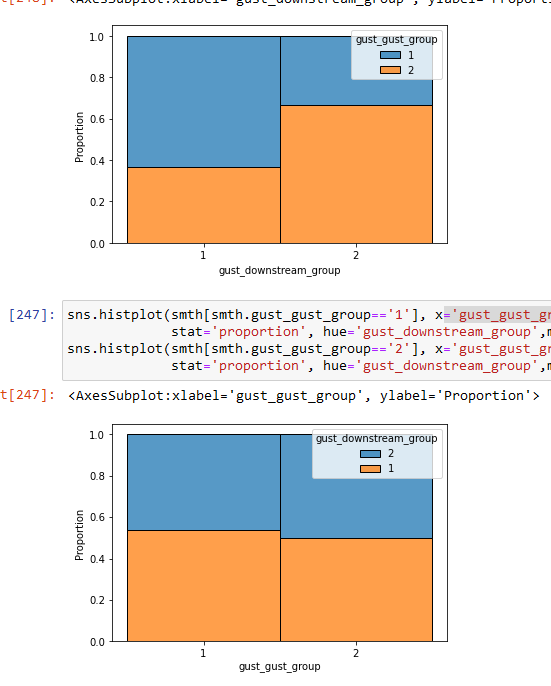

In [ ]:
counter_cosine_similarity(Counter(lst1_dwn), Counter(lst1_gust))

In [ ]:
counter_cosine_similarity(Counter(lst1_dwn), Counter(lst2_gust))

In [ ]:
counter_cosine_similarity(Counter(lst2_dwn), Counter(lst1_gust))

In [ ]:
counter_cosine_similarity(Counter(lst2_dwn), Counter(lst2_gust))

In [ ]:
counter_cosine_similarity(Counter(lst1_dwn), Counter(lst2_dwn))